In [1]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload  

In [2]:
import sascorer

In [3]:
torch.set_default_device('cuda')

In [4]:
from constants import *

In [5]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn

In [6]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv")
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [7]:
zinc250k.head(5)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [8]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

<Axes: >

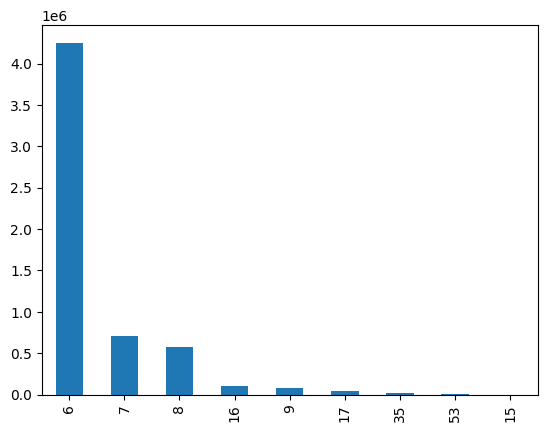

In [7]:
#pd.Series(counter).sort_values(ascending=False).plot.bar()

In [9]:
def graph_from_smiles(smiles):
    rdkit_mol=Chem.MolFromSmiles(smiles)
    X=[list(MOLS.keys()).index(i.GetAtomicNum()) for i in rdkit_mol.GetAtoms()]
    N=len(X)
    A=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            try:
                A[i,j]=BONDS[rdkit_mol.GetBondBetweenAtoms(i,j).GetBondType()]
            except:
                pass
    X=nn.functional.one_hot(torch.tensor(X), num_classes=len(MOLS))
    A=nn.functional.one_hot(A.to(int), num_classes=len(BONDS)).permute(-1,0,1)
    return X,A

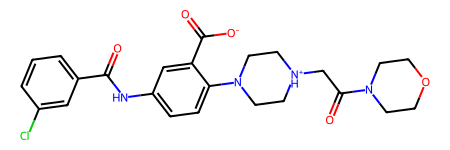

In [54]:
smiles_sample=sampled['smiles'][0]
x,a=graph_from_smiles(smiles_sample)
x=x.to(torch.float32).unsqueeze(0)
a=a.to(torch.float32).unsqueeze(0)
mol0=Chem.MolFromSmiles(smiles_sample)
mol0

In [10]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [33]:
g = G.Generator(32, [128, 256, 512], [], [], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([64, 32], [128,32], [128,32], [16,8])
r = R.Rewarder([64, 32], [128,32], [128,32], [16,8])

In [34]:
optimizer_r=torch.optim.AdamW(r.parameters(), lr=1e-3)

In [113]:
x,a=graph_from_smiles(zinc250k.iloc[0]['smiles'])
x=x.to(torch.float32).unsqueeze(0)
a=a.to(torch.float32).unsqueeze(0)

In [17]:
for (n,p) in r.named_parameters():
    print(n,(p!=p).any().detach().cpu())

layers.0.wr tensor(False)
layers.0.w0 tensor(False)
layers.1.wr tensor(False)
layers.1.w0 tensor(False)
i.0.wr tensor(False)
i.0.w0 tensor(False)
j.0.wr tensor(False)
j.0.w0 tensor(False)
final_mlp.layers.0.weight tensor(False)
final_mlp.layers.0.bias tensor(False)
final_mlp.layers.3.weight tensor(False)
final_mlp.layers.3.bias tensor(False)
final_mlp.layers.6.weight tensor(False)
final_mlp.layers.6.bias tensor(False)


In [14]:
r((x,a))

NameError: name 'x' is not defined

In [35]:
def train_rewardnet(rewardnet, optimizer, dataset):
    logp_t=lambda x:(min(max(logp_scale[0],x),logp_scale[1])-logp_scale[0])/(logp_scale[1]-logp_scale[0])
    qed_t=lambda x:(min(max(qed_scale[0],x),qed_scale[1])-qed_scale[0])/(qed_scale[1]-qed_scale[0])
    sas_t=lambda x:(min(max(sas_scale[0],x),sas_scale[1])-sas_scale[0])/(sas_scale[1]-sas_scale[0])
    iterator=tqdm(range(dataset.shape[0]))
    loss_ema = 0
    ema_n = 200
    for i in iterator:
        mol_smiles=dataset.iloc[i]['smiles']
        (x,a)=graph_from_smiles(mol_smiles)
        x=x.to(torch.float32).unsqueeze(0)
        a=a.to(torch.float32).unsqueeze(0)
        reward = logp_t(dataset.iloc[i]['logP']) * qed_t(dataset.iloc[i]['qed']) * sas_t(dataset.iloc[i]['SAS'])
        (rout,_)=r((x,a))
        rout = rout[0][0]
        #print(rout)
        mse = (rout-reward).abs()
        loss_ema = loss_ema * (1-1/ema_n) + (1/ema_n) * mse.detach().cpu()
        rewardnet.zero_grad(set_to_none=True)
        mse.backward()
        optimizer.step()
        iterator.set_description(f"loss:{loss_ema:.3f}. rout: {rout:.2f}. reward: {reward:.2f}")

In [ ]:
train_rewardnet(r, optimizer_r, zinc250k)

loss:0.064. rout: 0.19. reward: 0.03:  29%|██████████▊                          | 72975/249455 [17:37<38:25, 76.53it/s]

In [ ]:
def gamma_k(k, phi1, theta1, var_e=1):
    if k==0:
        return (var_e) * (1-2*phi1*theta1+theta1**2) / (1-phi1**2)
    elif k==1:
        return phi1*gamma_k(0, phi1, theta1, var_e=var_e)-theta1*(var_e)
    else:
        return (phi1**k)*gamma_k(k-1, phi1, theta1, var_e=var_e)
def rho_k(k, phi1, theta1, var_e=1):
    return gamma_k(k, phi1, theta1, var_e=var_e)/gamma_k(0, phi1, theta1, var_e=var_e)

In [ ]:
phi1=0.4
theta1=0.5
var=4
print("gamma_0", '%.4f' % gamma_k(0,phi1,theta1,var), sep='\t')
print("rho_1", '%.4f' % rho_k(1,phi1,theta1,var), sep='\t')

In [ ]:
gamma_k(0,0.4,-0.5,4)

In [ ]:
rho_k(1,0.6,0.3)